# #FormulaAI Hack 2022 - Challenge 1: Data Analytics

This Notebook is the main notebook of our repository. It walks you through from every-step of our story with the Challenge 1 from reading the data to evaluation of our model in a readable way. To get more details about the functions check out our src folder.

## Introduction

Formula 1 is one of the most competitive sports in the world where milliseconds matters. Engineers and technicians from every team use every data that they get in order to get ahead of their opponents. Ubimet provides weather radar screens to teams which allows them to track the current weather and make predictions during the race. Therefore weather forecasting takes a big part on the possible outcome of a race.

Similarly, F1 2021, the official Formula 1 videogame developed by Codemasters, uses a physics engine that behaves like the real world.

Our task was to use this generated data from Formula 1 Video Game and use it to forecast weather in 5,10,15,30,60 minutes intervals.

## Getting Started

In [1]:
# Import Libraries
import random
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import sklearn
import pickle

#Import Custom Module
from src.data_prep import prepare_datasets, get_dfs

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Set seeds in order to get consistent outputs
seed = 42
random.seed(seed)
np.random.seed(seed)

In [2]:
#Weather Classes
LABELS = {0: "clear",
          1: "light cloud",
          2: "overcast",
          3: "light rain",
          4: "heavy rain",
          5: "storm"}

single_val_cols = [
    "M_FORECAST_ACCURACY",
    "M_TOTAL_LAPS",
    'M_PIT_STOP_WINDOW_IDEAL_LAP',
    'M_PIT_STOP_WINDOW_LATEST_LAP',
    'M_PIT_STOP_REJOIN_POSITION',
    'M_STEERING_ASSIST',
    'M_BRAKING_ASSIST',
    'M_GEARBOX_ASSIST',
    'M_PIT_ASSIST',
    'M_PIT_RELEASE_ASSIST',
    'M_ERSASSIST',
    'M_DRSASSIST',
    'M_DYNAMIC_RACING_LINE',
    'M_DYNAMIC_RACING_LINE_TYPE'
]

multi_val_cols = [
    "M_WEATHER_FORECAST_SAMPLES_M_WEATHER",
    "M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE",
    "M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE",
    "M_TRACK_TEMPERATURE_CHANGE",
    "M_AIR_TEMPERATURE_CHANGE",
    "M_RAIN_PERCENTAGE"]


use_flag_info = False


In [9]:
# Read the Data 
if op.exists(op.join("data", "train.csv")) and op.exists(op.join("data", "val.csv")) and op.exists(op.join("data", "test.csv")):
    train_df = pd.read_csv(op.join("data", "train.csv"))
    val_df = pd.read_csv(op.join("data", "val.csv"))
    test_df = pd.read_csv(op.join("data", "test.csv"))
else:
    #If its the first time prepare the datasets 
    train_df, val_df, test_df = prepare_datasets(op.join("data", "weather.csv"), single_val_cols, multi_val_cols, use_flag_info=use_flag_info)

df_dct = {"train": train_df, "val": val_df, "test": test_df}
df_timed_dct = get_dfs(df_dct, single_val_cols, multi_val_cols)


c:\Users\Ege\Desktop\Side_Hustle\KuKu\src\data_prep.py:141: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Creating (session_uid, timestamp) pairs:


100%|██████████| 35651/35651 [02:00<00:00, 295.42it/s]


Converting into dataframe:


100%|██████████| 104964/104964 [02:26<00:00, 718.64it/s]


Creating dataset for time_offset=5
Creating dataset for time_offset=10
Creating dataset for time_offset=15
Creating dataset for time_offset=30
Creating dataset for time_offset=60


In [24]:
print("Time Offsets:",df_timed_dct.keys())
print("(Example) Datasets for 5 Minute Forecasting:",df_timed_dct["5"].keys())

Time Offsets: dict_keys(['5', '10', '15', '30', '60'])
(Example) Datasets for 5 Minute Forecasting: dict_keys(['train', 'val', 'test'])


# Exploratory Data Analysis
After we split the dataset to train,validation,test sets we see that there are only 3 classes available on the dataset.
By splitting each of the classes into 3 dataset x 5 time_offsets we got 15 datasets for our project.

In this part we try give you how data looks like after our process:

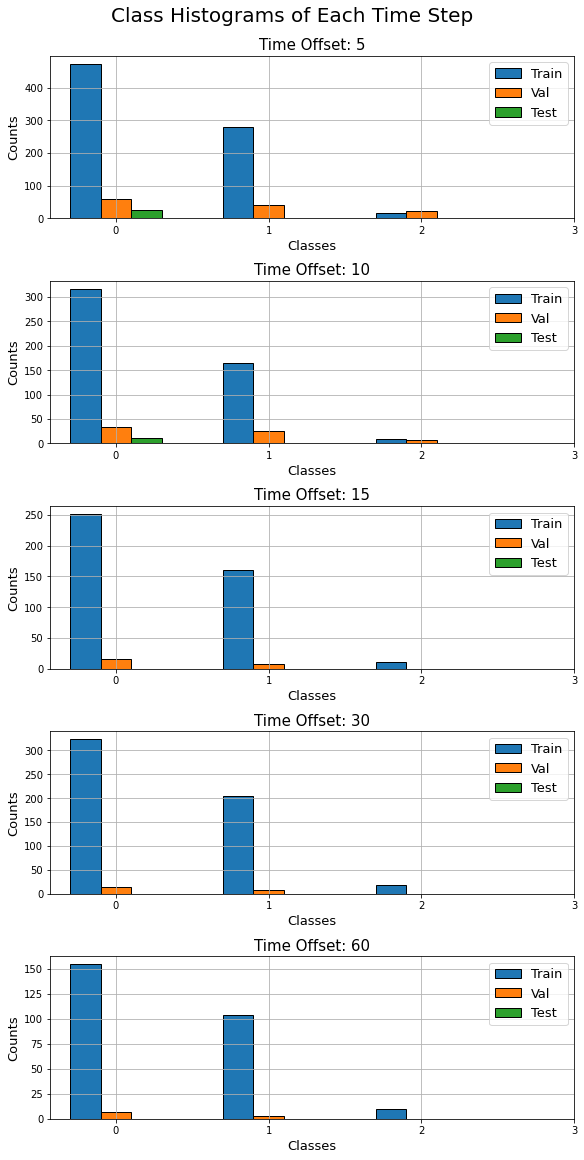

In [10]:
from src.plotting import plot_class_histograms
import copy

CLASS_IDX_BOUNDARY = 2

_df_timed_dct = copy.deepcopy(df_timed_dct)

df_timed_dct_subset = {}
for time_offset, df_timed in _df_timed_dct.items():
    df_timed_dct_subset[time_offset] = {}
    for typ, d_set in df_timed.items():
        df_timed_dct_subset[time_offset][typ] = d_set[d_set['TARGET_WEATHER'] <= CLASS_IDX_BOUNDARY].copy()
fig = plot_class_histograms(df_timed_dct_subset, max_class_idx=CLASS_IDX_BOUNDARY+1)


C:\ProgramData\Anaconda3\envs\py38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TARGET_RAIN_PERCENTAGE', ylabel='Density'>

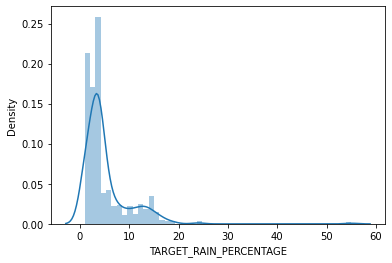

In [11]:
sns.distplot(df_timed_dct["5"]["train"]["TARGET_RAIN_PERCENTAGE"],kde=True)


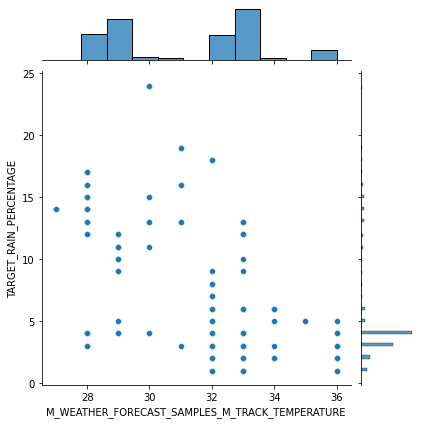

In [ ]:
sns.jointplot(x="M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE",
 y="TARGET_RAIN_PERCENTAGE", data=df_timed_dct["5"]["train"])


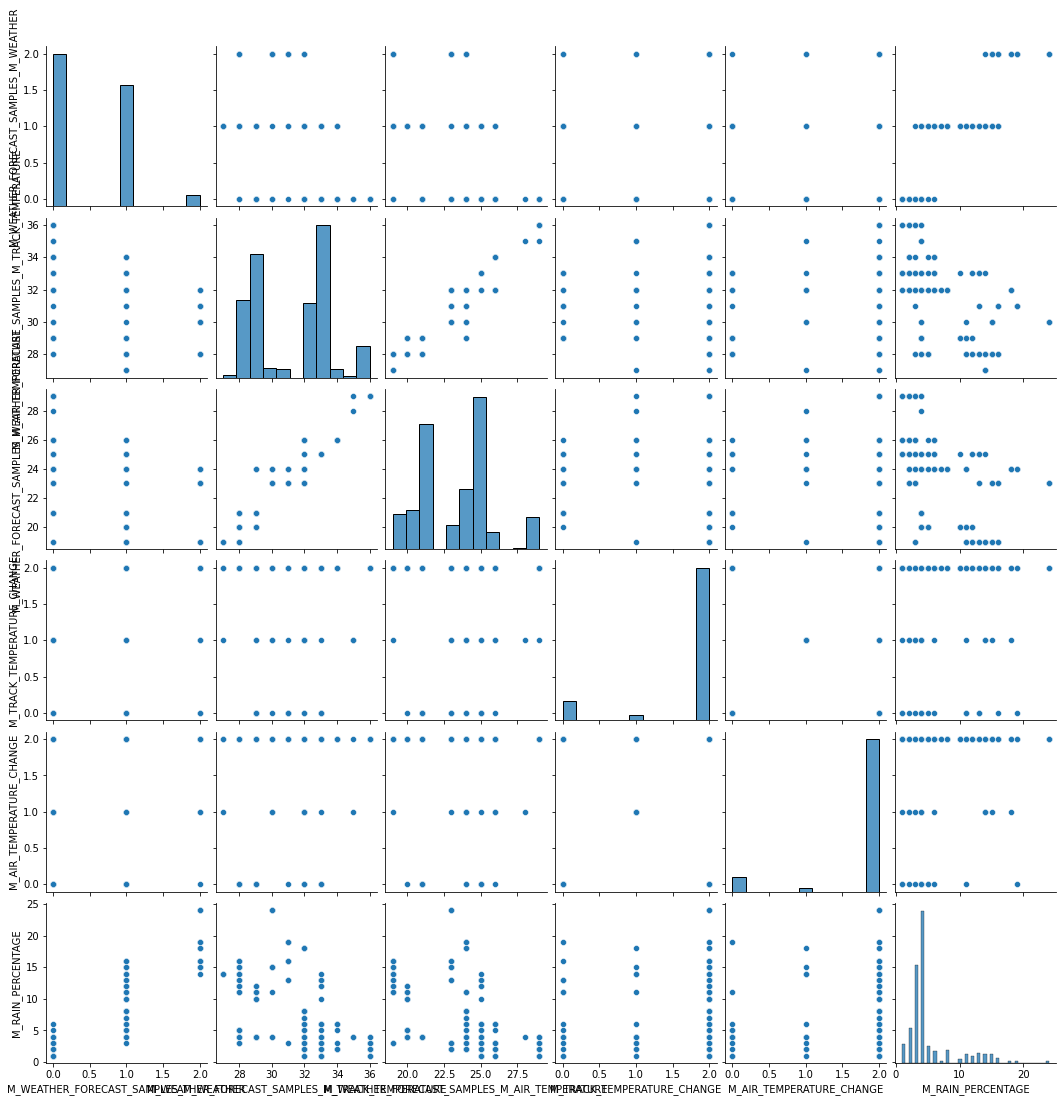

In [ ]:
table = data = df_timed_dct["5"]["train"]
sns.pairplot(table[multi_val_cols])


# Model Training & Evaluation

## Weather

c:\Users\Ege\Desktop\Side_Hustle\KuKu\src\plotting.py:118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\ProgramData\Anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ege\Desktop\Side_Hustle\KuKu\src\plotting.py:118: DataConversionWarning: A column-vector y was passed whe

ValueError: Found array with 0 sample(s) (shape=(0, 25)) while a minimum of 1 is required by StandardScaler.

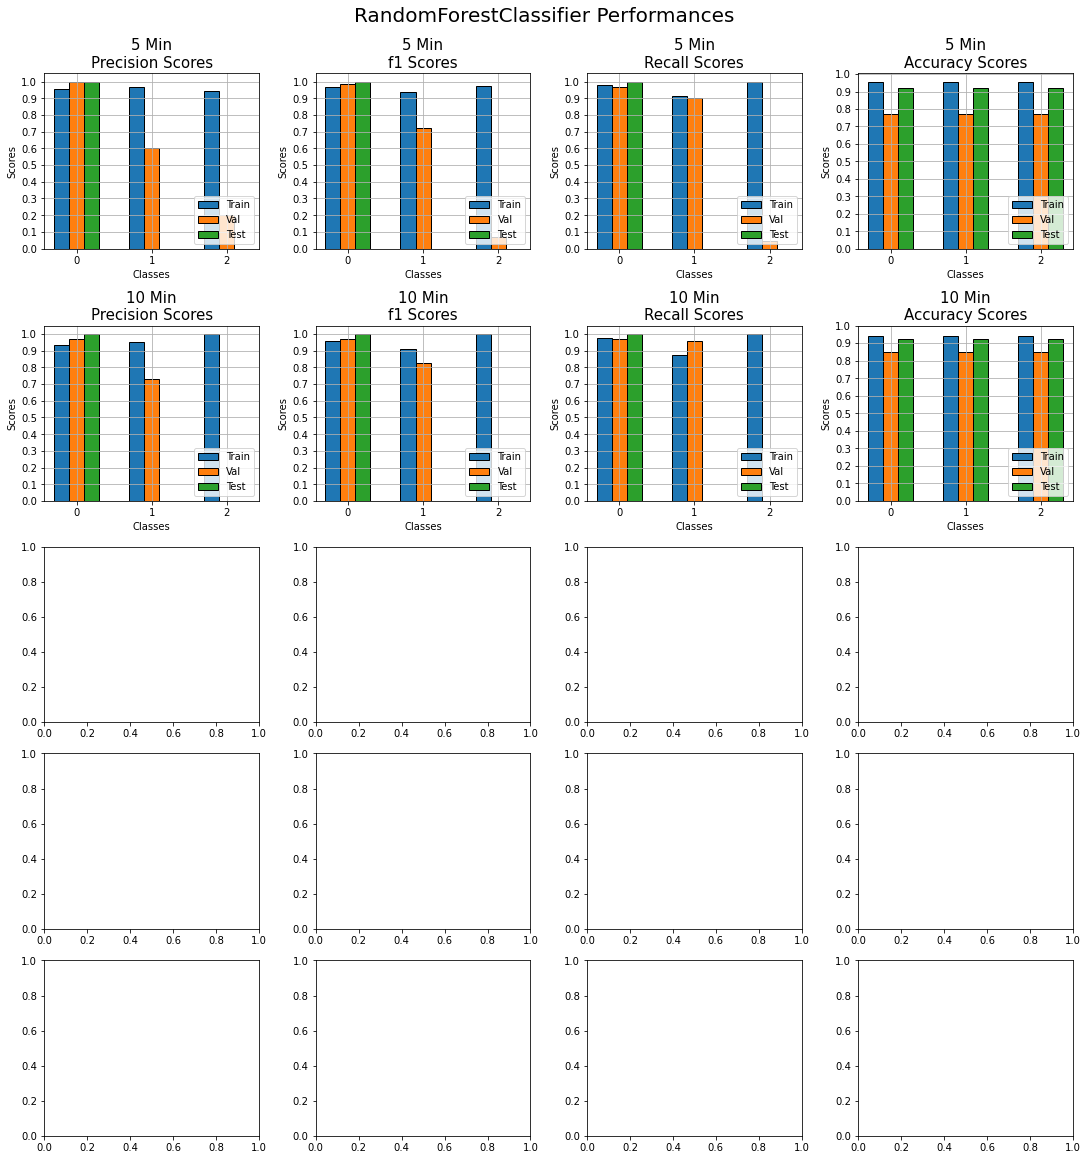

In [12]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from src.plotting import plot_model_performance

model = RandomForestClassifier(max_depth=10, random_state=0)
# pipeline = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
plot_model_performance(model, df_timed_dct_subset, model_type="weather", save=False)


## Rain Percentage

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=5, random_state=0)
plot_model_performance(model, df_timed_dct_subset, model_type="rain_percentage", save=False)


/Users/haldunbalim/Desktop/KuKu/plot.py:118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Train MAE: 0.24116187100478642
Val MAE: 1.1920268096371107
Test MAE: 1.3753584198873374

Train MAE: 0.3108515952106674
Val MAE: 2.0471277169050484
Test MAE: 2.8446667611077556



/Users/haldunbalim/Desktop/KuKu/plot.py:118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/Users/haldunbalim/Desktop/KuKu/plot.py:118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Train MAE: 0.32535373047586624
Val MAE: 2.8433448657208675
Test MAE: 4.678089116511499

Train MAE: 0.4368962352155224
Val MAE: 4.668916200658173
Test MAE: 6.403711065141063



/Users/haldunbalim/Desktop/KuKu/plot.py:118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/Users/haldunbalim/Desktop/KuKu/plot.py:118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Train MAE: 0.33460539206381795
Val MAE: 4.5917902449179575
Test MAE: 7.176089420207825



# Export Model

In [ ]:
class Model:
    def __init__(self, classifier_model, regressor_model, cols):
        self.time_offsets = ["5", "10", "15", "30", "60"]
        self.cols = cols
        self.classifiers = [sklearn.base.clone(
            classifier_model) for _ in range(5)]
        self.regressors = [sklearn.base.clone(
            regressor_model) for _ in range(5)]

    def fit(self, df_timed_dct):
        for i, time_offset in enumerate(self.time_offsets):
            table = df_timed_dct[time_offset]["train"]
            target_cols = ["TARGET_RAIN_PERCENTAGE", "TARGET_WEATHER"]
            table = table[self.cols + target_cols]
            X = table[table.columns[:-2]]
            weather = table[table.columns[-1]]
            rain_percent = table[table.columns[-2]]
            self.classifiers[i].fit(X, weather)
            self.regressors[i].fit(X, rain_percent)

    def predict(self, row):
        if np.sum(row.isna()) > 0:
            return np.nan
        weather_preds = [classifier.predict(
            [row[self.cols]])[0] for classifier in self.classifiers]
        rain_percent_preds = [regressor.predict(
            [row[self.cols]])[0] for regressor in self.regressors]
        return {ts: {'type': weather, str(weather): rain_percent}
                for ts, weather, rain_percent in zip(self.time_offsets, weather_preds, rain_percent_preds)}


In [ ]:
cls_temp = RandomForestClassifier(max_depth=10, random_state=0)
reg_temp = RandomForestRegressor(max_depth=5, random_state=0)
model = Model(cls_temp, reg_temp, cols=single_val_cols+multi_val_cols)
model.fit(df_timed_dct)
with open("model.pkl","wb") as file:
    pickle.dump(model, file)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
